### Paketimporte

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import locale

### Vorbereitung der Daten

Preise

In [3]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx")
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

Downtime

In [4]:
df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

Kundendaten

In [5]:
df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

Vereinen der Transaktionsdaten

In [6]:
def read_regio_data(region, kind):
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        year_month=lambda _data: _data["date"].dt.year.astype(str) + "_" + _data["date"].dt.month.astype(str),
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "transaction_id"]], on="transaction_id"))

df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifische Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

In [13]:
df_stores = df_reg_main[df_reg_main["marketplace"] == "store"]

### Erstellen der Grafiken für die Präsentation

#### Funktionen für die Graphen erzeugen

In [40]:
# Create a custom formatter function for the y-axis
def millions_formatter(x, pos):
    return "%1.f Mio." % (x * 1e-6)

# Generic formatting for lineplot
def format_lineplot():
    # Define the plot size
    # plt.figure(figsize=(10, 6))

    # Set the locale to German to ensure month names are in German
    locale.setlocale(locale.LC_TIME, "de_DE.UTF-8")

    # Create a MonthLocator object to ensure ticks are set at monthly intervals
    locator = mdates.MonthLocator()

    # Set the locator for the x-axis
    plt.gca().xaxis.set_major_locator(locator)

    # Format x-axis with German months in abbreviated form and year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

    # Optionally, set the x-tick labels rotation
    plt.xticks(rotation=45)

    # Set the starting point of the y-axis to 0
    plt.gca().set_ylim(bottom=0)

    # Remove the y-axis and x-axis label
    plt.gca().set_ylabel("")
    plt.gca().set_xlabel("")

    # Add grid lines for better readability
    plt.grid(which="both", axis="both", linestyle="--", linewidth=0.5)

def format_lineplot2(ax):
    # Set the locale to German to ensure month names are in German
    locale.setlocale(locale.LC_TIME, "de_DE.UTF-8")

    # Create a MonthLocator object to ensure ticks are set at monthly intervals
    locator = mdates.MonthLocator()

    # Set the locator for the x-axis
    ax.xaxis.set_major_locator(locator)

    # Format x-axis with German months in abbreviated form and year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

    # Optionally, set the x-tick labels rotation
    ax.tick_params(axis="x", rotation=45)

    # Set the starting point of the y-axis to 0
    ax.set_ylim(bottom=0)

    # Remove the y-axis and x-axis label
    ax.set_ylabel("")
    ax.set_xlabel("")

    # Add grid lines for better readability
    ax.grid(which="both", axis="both", linestyle="--", linewidth=0.5)

#### Graphen erzeugen

Regionen und die Markplätze zum Vergleich an

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


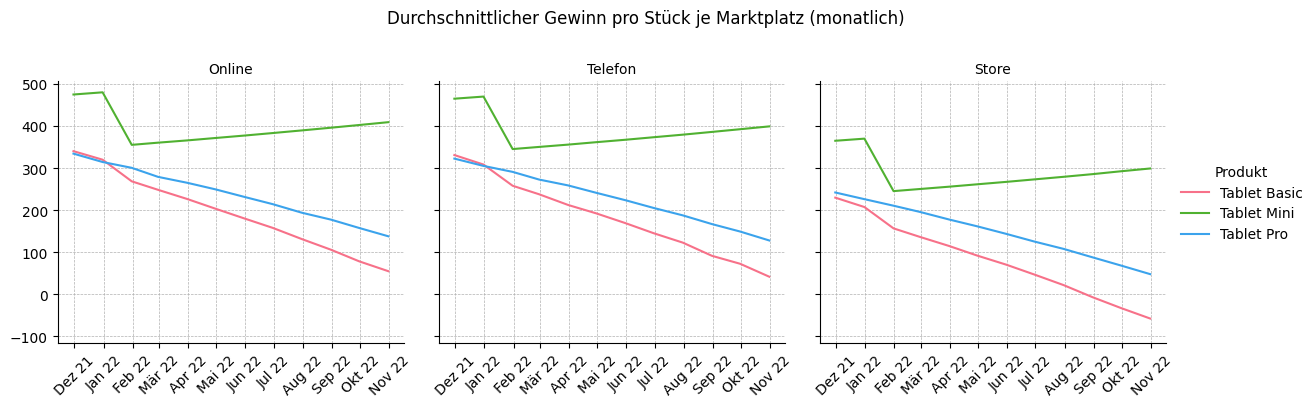

In [50]:
# Group by Month, product and marketplace and aggregate the profit and amount. Rename the marketplaces to German
df = (
    df_reg_main.groupby([pd.Grouper(key="date", freq="1M"), "product", "marketplace"])
        .agg({"profit": "sum", "amount": "sum"})
        .reset_index()
        .replace(["online", "phone", "store"], ["Online", "Telefon", "Store"])
)

df["profit/amount"] = df["profit"] / df["amount"]

# Create a FacetGrid, using 'marketplace' for different columns
g = sns.FacetGrid(df, col="marketplace", col_wrap=3, sharex=True, sharey=True, height=4)

# Map the lineplot to each facet
g = g.map_dataframe(sns.lineplot, x="date", y="profit/amount", hue="product", palette="husl")

# Apply the formatting to each subplot
for ax in g.axes.flat:
    format_lineplot2(ax)

# Additional formatting for the grid
g.add_legend(title="Produkt")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.8)  # Adjust the top to make space for the main title
g.fig.suptitle("Durchschnittlicher Gewinn pro Stück je Marktplatz (monatlich)")

min_profit = df["profit/amount"].min()
plt.gca().set_ylim(bottom=min_profit + min_profit * 1)

plt.gca().set_ylabel("Gewinn p. Stück")

# Display the plot
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


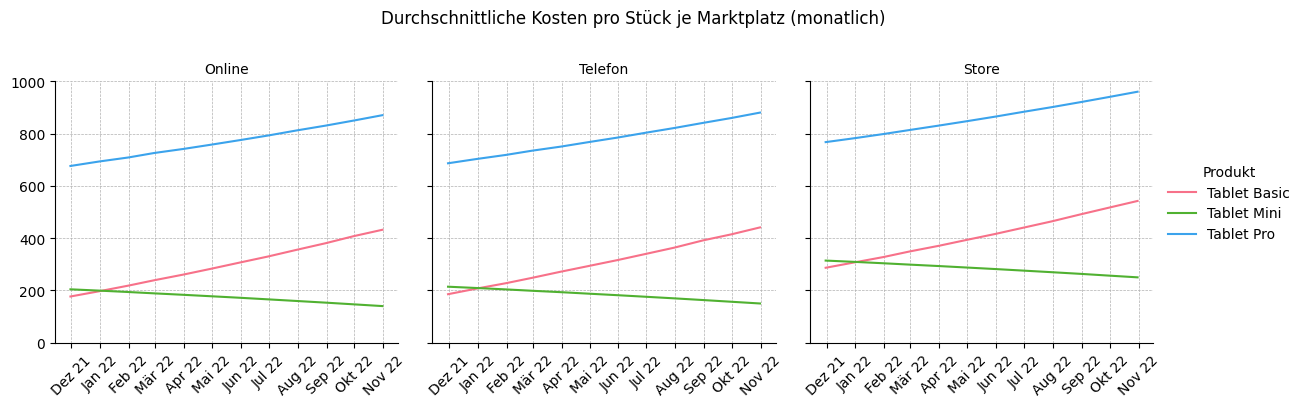

In [54]:
# Group by Month, product and marketplace and aggregate the profit and amount. Rename the marketplaces to German
df = (
    df_reg_main.groupby([pd.Grouper(key="date", freq="1M"), "product", "marketplace"])
        .agg({"cost_per_unit": "mean"})
        .reset_index()
        .replace(["online", "phone", "store"], ["Online", "Telefon", "Store"])
)

# Create a FacetGrid, using 'marketplace' for different columns
g = sns.FacetGrid(df, col="marketplace", col_wrap=3, sharex=True, sharey=True, height=4)

# Map the lineplot to each facet
g = g.map_dataframe(sns.lineplot, x="date", y="cost_per_unit", hue="product", palette="husl")

# Apply the formatting to each subplot
for ax in g.axes.flat:
    format_lineplot2(ax)

# Additional formatting for the grid
g.add_legend(title="Produkt")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.8)  # Adjust the top to make space for the main title
g.fig.suptitle("Durchschnittliche Kosten pro Stück je Marktplatz (monatlich)")

plt.gca().set_ylabel("Gewinn p. Stück")

# Display the plot
plt.show()

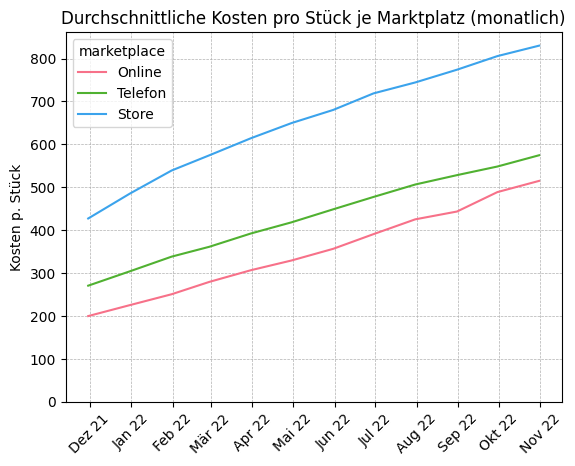

In [60]:
# Group by Month, product and marketplace and aggregate the profit and amount. Rename the marketplaces to German
df = (
    df_reg_main.groupby([pd.Grouper(key="date", freq="1M"), "marketplace"])
        .agg({"cost_per_unit": "mean"})
        .reset_index()
        .replace(["online", "phone", "store"], ["Online", "Telefon", "Store"])
)

# Map the lineplot to each facet
sns.lineplot(df, x="date", y="cost_per_unit", hue="marketplace", palette="husl")

format_lineplot()

# Additional formatting for the grid
plt.title("Durchschnittliche Kosten pro Stück je Marktplatz (monatlich)")

plt.gca().set_ylabel("Kosten p. Stück")

# Display the plot
plt.show()

Kosten

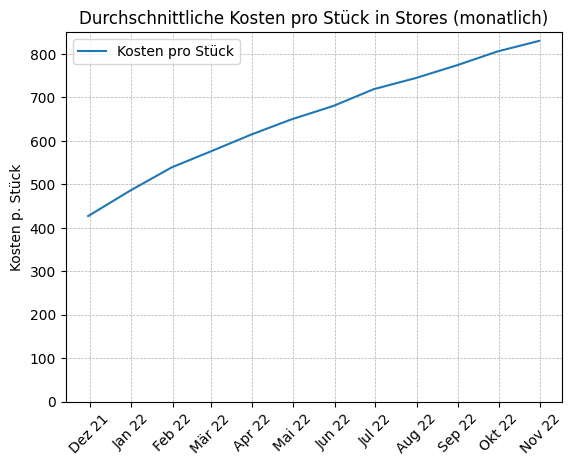

In [48]:
df = df_stores.groupby(pd.Grouper(key="date", freq="1M")).agg(
    {"cost_per_unit": "mean"}
)

sns.lineplot(data=df, x="date", y="cost_per_unit", label="Kosten pro Stück")

format_lineplot()
plt.title("Durchschnittliche Kosten pro Stück in Stores (monatlich)")

plt.gca().set_ylabel("Kosten p. Stück")

plt.show()

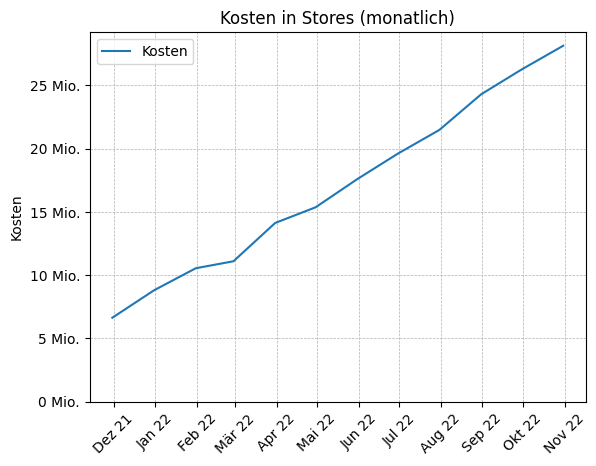

In [47]:
df = df_stores.groupby(pd.Grouper(key="date", freq="1M")).agg(
    {"cost": "sum"}
)

sns.lineplot(data=df, x="date", y="cost", label="Kosten")

format_lineplot()
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.title("Kosten in Stores (monatlich)")

plt.gca().set_ylabel("Kosten")

plt.show()

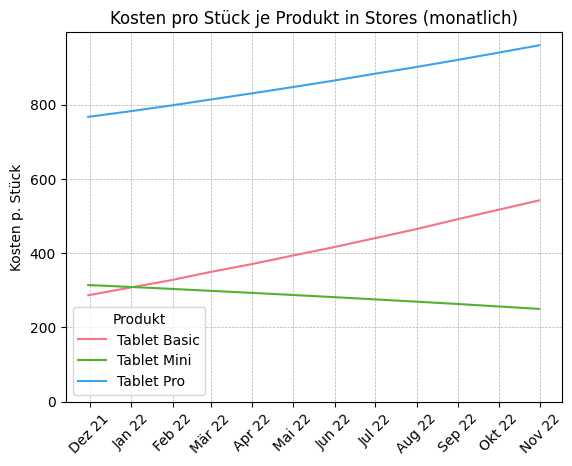

In [36]:
df = (
    df_stores.groupby([pd.Grouper(key="date", freq="1M"), "product"])
    .agg({"cost_per_unit": "mean"})
    .reset_index()
)

sns.lineplot(data=df, x="date", y="cost_per_unit", hue="product", palette="husl")

format_lineplot()
plt.title("Kosten pro Stück je Produkt in Stores (monatlich)")
plt.legend(
    title="Produkt"
)

plt.gca().set_ylabel("Kosten p. Stück")

plt.show()